# Example: Neural Networks in larger models

Before runnning this notebook, make sure that all neccesary libraries are installed:

In [1]:
using Flux
using Random
using Gogeta
using Plots
using Gurobi
using JuMP

In some of the previous examples, related to the neural networks we mentioned that we can add some additional constraints to formulation of the NN. In those examples, after formulation of the NN, we were manually extracting the needed input variables from the formulation. But in this Jupyter notebook, we are going to present a more efficient way how to use NN in larger optimization models.

## Some innitial constraints 

Let input variables are $x\in [-1.5, -0.5]$ and $y\in[-0.5,0.5]$. 

We also know that $y\geq -x-1$. 

There is also some arbitraty function $f(x,y)$ and we don't know it explicitly, but it can be represented by surrogate model - trained NN.

In [190]:
# Create a small neural network with random weights
begin
    Random.seed!(1234);

    NN_model = Chain(
        Dense(2 => 10, relu),
        Dense(10 => 50, relu),
        Dense(50 => 20, relu),
        Dense(20 => 5, relu),
        Dense(5 => 1)
    )
end

# Set upper and lower input bounds
init_U = [-0.5, 0.5];
init_L = [-1.5, -0.5];

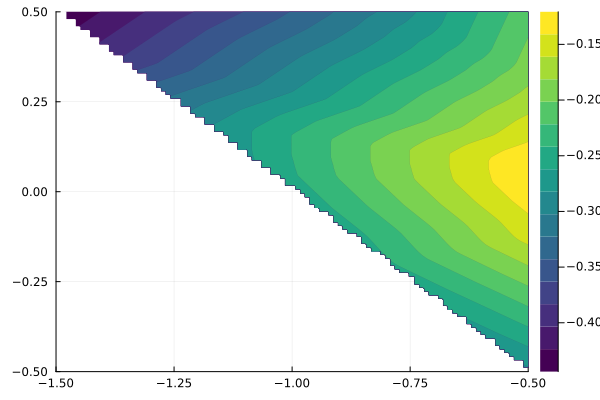

In [192]:
# contour plot the model in the feasible region of the following optimization problem
x_range = LinRange{Float32}(init_L[1], init_U[1], 100);
y_range = LinRange{Float32}(init_L[2], init_U[2], 100);

contourf(x_range, y_range, (x, y) -> if y >= -x-1 NN_model(hcat(x, y)')[] else NaN end, c=cgrad(:viridis), lw=0)


Create `JuMP` model

In [221]:
jump_model = Model(Gurobi.Optimizer)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20


A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Gurobi

Add varible that would be associated with neural network output

In [222]:
@variable(jump_model, output);

output

Add input variables

In [223]:
@variable(jump_model, x);
@variable(jump_model, y);

Add some additional constraints associated with input variables

In [224]:
@constraint(jump_model, y >= -x - 1);

The objective function can be anything you want. Suppose, you want to find $$\text{max } f(x,y) - 0.5x$$

In [226]:
@objective(jump_model, Max, output - 0.5*x);

Don't forget to set up sover

In [213]:
function set_solver!(jump)
    set_optimizer(jump, () -> Gurobi.Optimizer())
    set_silent(jump)
end

set_solver! (generic function with 1 method)

In [228]:
NN_incorporate!(jump_model, NN_model, output, x, y; U_in=init_U, L_in=init_L, bound_tightening="standard")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-05-20
LAYER: 1
Neuron: 1, bounds: [0.16892524808645248, 0.7776865735650063]
Neuron: 2, bounds: [-0.2680980712175369, 0.04221390187740326]
Neuron: 3, bounds: [-0.4801315367221832, 0.10741600394248962]
Neuron: 4, bounds: [-0.17742440849542618, 0.42832256108522415]
Neuron: 5, bounds: [-0.2498505935072899, 0.5106385871767998]
Neuron: 6, bounds: [-1.3318716883659363, -0.0035308003425598145]
Neuron: 7, bounds: [0.21568965166807175, 0.9142742231488228]
Neuron: 8, bounds: [0.08210700750350952, 1.2899381518363953]
Neuron: 9, bounds: [-0.14929509907960892, 0.5632241740822792]
Neuron: 10, bounds: [-0.35886954702436924, 0.30129695124924183]
LAYER: 2
Neuron: 1, bounds: [-0.12547269429612573, 0.037194365048506234]
Neuron: 2, bounds: [-0.06294386866393845, 0.31779047307278585]
Neuron: 3, bounds: [-0.14803691535043573, 0.11205503448821985]
Neuron: 4, bounds: [0.008051302098601158, 0.2838730166168629]
Neuron: 5, bounds

IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting)))

In [229]:
optimize!(jump_model)

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M1 Pro
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 432 rows, 263 columns and 2267 nonzeros
Model fingerprint: 0xdf16c5ba
Variable types: 178 continuous, 85 integer (85 binary)
Coefficient statistics:
  Matrix range     [2e-05, 1e+00]
  Objective range  [5e-01, 1e+00]
  Bounds range     [5e-01, 2e+00]
  RHS range        [5e-04, 1e+00]
Presolve removed 280 rows and 110 columns
Presolve time: 0.01s
Presolved: 152 rows, 153 columns, 1518 nonzeros
Variable types: 119 continuous, 34 integer (34 binary)

Root relaxation: objective 3.667827e-01, 114 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.36678    0   14          -    0.36678      -     -    0s
H    0     0            

In [230]:
solution_summary(jump_model)

* Solver : Gurobi

* Status
  Result count       : 3
  Termination status : OPTIMAL
  Message from the solver:
  "Model was solved to optimality (subject to tolerances), and an optimal solution is available."

* Candidate solution (result #1)
  Primal status      : FEASIBLE_POINT
  Dual status        : NO_SOLUTION
  Objective value    : 3.09040e-01
  Objective bound    : 3.09066e-01
  Relative gap       : 8.35390e-05
  Dual objective value : 3.09066e-01

* Work counters
  Solve time (sec)   : 6.03609e-02
  Barrier iterations : 0
  Node count         : 1


In [231]:
value(x), value(y)

(-1.2609439405453131, 0.2609439405453131)

In [232]:
# check that NN formulation matches Flux model
set_silent(jump_model)
check = [if y_in >= -x_in-1 forward_pass_NN!(jump_model, [x_in, y_in], output, x, y) ≈ NN_model(hcat(x_in, y_in)')[] end for x_in in x_range, y_in in y_range]
all(value -> value === nothing || value == true, check)

Error with forward pass: InterruptException()


┌ Warning: Input or output outside of bounds or incorrectly constructed model.
└ @ Main In[202]:243


LoadError: Gurobi Error 10017: Unable to set attribute 'LB'